# preprocessing

> This module is used for the preprocessing of a dataset and the retrieval of the result

In [ ]:
#| default_exp preprocessing

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from functools import partial
from IPython.display import Audio

import torchaudio

from birdclef.utils import plot_audio, DATA_DIR, AUDIO_DATA_DIR

Download the data from the [Kaggle competition](https://www.kaggle.com/competitions/birdclef-2023/overview). Save the *train_metadata.csv* file as *metadata.csv* in the *data* directory. Save the *train_audio* as *audio_data* folder inside the *data* folder.

## Data exploration and processing

### Loading dataset

In [ ]:
metadata = pd.read_csv(DATA_DIR + "metadata.csv")
metadata

primary_label secondary_labels              type  latitude  longitude  \
0           abethr1               []          ['song']    4.3906    38.2788   
1           abethr1               []          ['call']   -2.9524    38.2921   
2           abethr1               []          ['song']   -2.9524    38.2921   
3           abethr1               []          ['song']   -2.9524    38.2921   
4           abethr1               []  ['call', 'song']   -2.9524    38.2921   
...             ...              ...               ...       ...        ...   
16936       yewgre1               []              ['']   -1.2502    29.7971   
16937       yewgre1               []              ['']   -1.2489    29.7923   
16938       yewgre1               []              ['']   -1.2433    29.7844   
16939       yewgre1               []              ['']    0.0452    36.3699   
16940       yewgre1               []              ['']   -0.3986    37.3087   

            scientific_name                common_name          author  \
0        Turdus tephronotus   African Bare-eyed Thrush   Rolf A. de By   
1        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
2        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
3        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
4        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
...                     ...                        ...             ...   
16936  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16937  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16938  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16939  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   
16940  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   

                                                 license  rating  \
0      Creative Commons Attribution-NonCommercial-Sha...     4.0   
1      Creative Commons Attribution-NonCommercial-Sha...     3.5   
2      Creative Commons Attribution-NonCommercial-Sha...     3.5   
3      Creative Commons Attribution-NonCommercial-Sha...     5.0   
4      Creative Commons Attribution-NonCommercial-Sha...     4.5   
...                                                  ...     ...   
16936  Creative Commons Attribution-NonCommercial-Sha...     3.0   
16937  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16938  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16939  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16940  Creative Commons Attribution-NonCommercial-Sha...     4.5   

                                     url              filename  
0      https://www.xeno-canto.org/128013  abethr1/XC128013.ogg  
1      https://www.xeno-canto.org/363501  abethr1/XC363501.ogg  
2      https://www.xeno-canto.org/363502  abethr1/XC363502.ogg  
3      https://www.xeno-canto.org/363503  abethr1/XC363503.ogg  
4      https://www.xeno-canto.org/363504  abethr1/XC363504.ogg  
...                                  ...                   ...  
16936      https://xeno-canto.org/703472  yewgre1/XC703472.ogg  
16937      https://xeno-canto.org/703485  yewgre1/XC703485.ogg  
16938      https://xeno-canto.org/704433  yewgre1/XC704433.ogg  
16939      https://xeno-canto.org/752974  yewgre1/XC752974.ogg  
16940      https://xeno-canto.org/753190  yewgre1/XC753190.ogg  

[16941 rows x 12 columns]

### Exploring labels

In [ ]:
#| eval: false
metadata['primary_label'].value_counts()

primary_label
barswa     500
wlwwar     500
thrnig1    500
eaywag1    500
comsan     500
          ... 
lotcor1      1
whctur2      1
whhsaw1      1
afpkin1      1
crefra2      1
Name: count, Length: 264, dtype: int64

We have 16941 audios described by 11 features and one label. There 246 different bird species.

<Axes: xlabel='primary_label'>

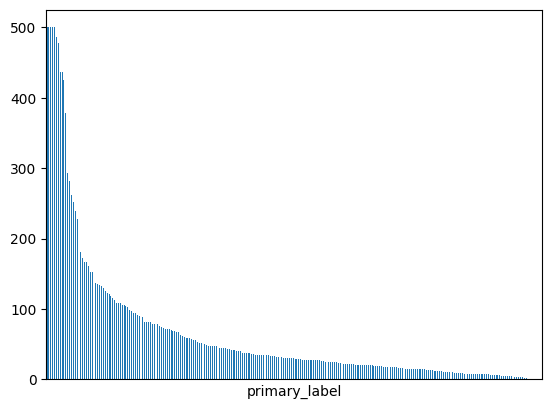

In [ ]:
#| eval: false
metadata['primary_label'].value_counts().plot(kind='bar', xticks=[])

As it is possible to see from the plot the distribution of the species is very unbalanced. We will have to deal with some species having very few audio representing them.

### Exploring numerical features

In [ ]:
#| eval: false
metadata.describe()

latitude     longitude        rating
count  16714.000000  16714.000000  16941.000000
mean      12.599897     22.035690      3.727732
std       29.208254     28.743382      1.101060
min      -38.116900   -157.819400      0.000000
25%       -6.256000      5.941125      3.000000
50%        2.359500     26.750650      4.000000
75%       42.787100     36.589850      4.500000
max       71.976900    177.684900      5.000000

From the description of the numeric attributes we can notice some things:

There are some audio files whose rating is 0 or very low. In order not to have "bad" data to taint the train and test set, we could filter them out.

### Filtering out bad ratied audios

To decide which rating threshold to use let's have a look at the quantiles of the ratings.

In [ ]:
#| eval: false
metadata.quantile([0.05, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.25], numeric_only=True)

latitude  longitude  rating
0.05 -33.294500 -13.361650     2.0
0.10 -26.821470  -6.263530     2.5
0.11 -26.735357  -6.039683     2.5
0.12 -26.450108  -4.945000     2.5
0.13 -25.307317  -4.053300     2.5
0.14 -24.383400  -2.983300     3.0
0.15 -22.456575  -1.760600     3.0
0.20  -8.500000   1.785600     3.0
0.25  -6.256000   5.941125     3.0

By having a look at the quantiles we can note that by eliminating all audios below 3 stars we would loose ca 14% of the data. Let's do it!

In [ ]:
good_metadata = metadata.loc[metadata.rating >= 3]
good_metadata

primary_label secondary_labels              type  latitude  longitude  \
0           abethr1               []          ['song']    4.3906    38.2788   
1           abethr1               []          ['call']   -2.9524    38.2921   
2           abethr1               []          ['song']   -2.9524    38.2921   
3           abethr1               []          ['song']   -2.9524    38.2921   
4           abethr1               []  ['call', 'song']   -2.9524    38.2921   
...             ...              ...               ...       ...        ...   
16936       yewgre1               []              ['']   -1.2502    29.7971   
16937       yewgre1               []              ['']   -1.2489    29.7923   
16938       yewgre1               []              ['']   -1.2433    29.7844   
16939       yewgre1               []              ['']    0.0452    36.3699   
16940       yewgre1               []              ['']   -0.3986    37.3087   

            scientific_name                common_name          author  \
0        Turdus tephronotus   African Bare-eyed Thrush   Rolf A. de By   
1        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
2        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
3        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
4        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
...                     ...                        ...             ...   
16936  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16937  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16938  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16939  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   
16940  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   

                                                 license  rating  \
0      Creative Commons Attribution-NonCommercial-Sha...     4.0   
1      Creative Commons Attribution-NonCommercial-Sha...     3.5   
2      Creative Commons Attribution-NonCommercial-Sha...     3.5   
3      Creative Commons Attribution-NonCommercial-Sha...     5.0   
4      Creative Commons Attribution-NonCommercial-Sha...     4.5   
...                                                  ...     ...   
16936  Creative Commons Attribution-NonCommercial-Sha...     3.0   
16937  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16938  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16939  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16940  Creative Commons Attribution-NonCommercial-Sha...     4.5   

                                     url              filename  
0      https://www.xeno-canto.org/128013  abethr1/XC128013.ogg  
1      https://www.xeno-canto.org/363501  abethr1/XC363501.ogg  
2      https://www.xeno-canto.org/363502  abethr1/XC363502.ogg  
3      https://www.xeno-canto.org/363503  abethr1/XC363503.ogg  
4      https://www.xeno-canto.org/363504  abethr1/XC363504.ogg  
...                                  ...                   ...  
16936      https://xeno-canto.org/703472  yewgre1/XC703472.ogg  
16937      https://xeno-canto.org/703485  yewgre1/XC703485.ogg  
16938      https://xeno-canto.org/704433  yewgre1/XC704433.ogg  
16939      https://xeno-canto.org/752974  yewgre1/XC752974.ogg  
16940      https://xeno-canto.org/753190  yewgre1/XC753190.ogg  

[14620 rows x 12 columns]

In [ ]:
species_count = good_metadata['primary_label'].value_counts()
species_count

primary_label
thrnig1    449
wlwwar     446
barswa     443
combuz1    420
woosan     420
          ... 
golher1      1
whctur2      1
whhsaw1      1
lotcor1      1
rehblu1      1
Name: count, Length: 264, dtype: int64

We can appreciate the fact that even having removed all audio with rating below 3 we still have samples representing all classes.

### Exploring audio types

Let's have a look at the audio types.

In [ ]:
types = good_metadata['type']
flat_types = [sound_type for sublist in types for sound_type in eval(sublist)]
pd.Series(flat_types).value_counts()

call                            5811
song                            5540
flight call                     1867
adult                           1728
                                1646
                                ... 
call-song                          1
metallic call                      1
only plik calls in migration       1
"S" call                           1
demonstrative tapping              1
Name: count, Length: 347, dtype: int64

<Axes: >

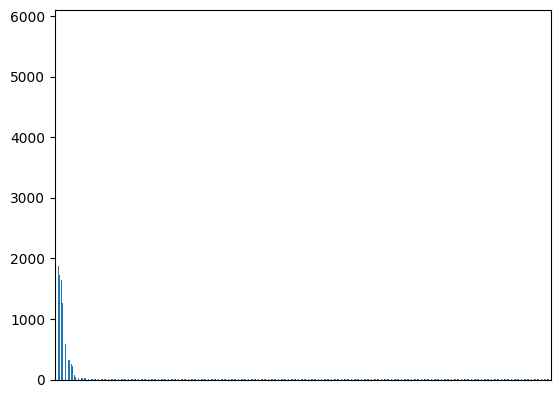

In [ ]:
#| eval: false
pd.Series(flat_types).value_counts().plot(kind='bar', xticks=[])

Some of them are very frequent. Maybe this information could be used in some way.

### Dealing with low represented species

As we have seen before there are some species that are represented by just one or two audio files. This is obviously not a good thing because when we will divide the dataset in train, validation and test sets we will end up with some species that will not be represented in all splits.

In addition, pecies that have very few instances are not statistically relevant to train a model to recognize them.

We could either find a way to oversample them or merge them into an "unknowkn" class.

#### Alternative A - Oversampling

To overcome the problem we could split the relevant audios in chuncks to increment their cardinality.

Let's start by looking at how many species are affected by this problem.

In [ ]:
#| eval: false
species_count.loc[species_count < 10]

primary_label
rostur1    9
grccra1    9
whcpri2    9
gybfis1    9
brcale1    8
hipbab1    8
spfwea1    8
mcptit1    8
brrwhe3    8
yenspu1    8
chewea1    8
afgfly1    8
bltapa1    8
whrshr1    7
equaka1    7
refwar2    7
tacsun1    6
joygre1    6
bltbar1    6
gytbar1    6
pabspa1    6
bawman1    6
bubwar2    6
kvbsun1    6
purgre2    6
sacibi2    6
rufcha2    6
darter3    6
whbcro2    5
chespa1    5
dutdov1    5
witswa1    5
palpri1    4
macshr1    4
rehwea1    4
gobwea1    4
hunsun2    4
stusta1    4
fatwid1    3
brcsta1    3
lotlap1    3
marsto1    3
shesta1    3
gobsta5    3
dotbar1    2
brcwea1    2
crefra2    1
afpkin1    1
yebsto1    1
brtcha1    1
golher1    1
whctur2    1
whhsaw1    1
lotcor1    1
rehblu1    1
Name: count, dtype: int64

It is time to define a function to split the audio into chuncks.

In [ ]:
def split_audio(chuncks, entry):
    path = AUDIO_DATA_DIR + entry.filename
    old_name = entry.filename

    waveform, sample_rate = torchaudio.load(path)

    remainder = waveform.shape[1] % chuncks

    if remainder != 0:
        waveform = waveform[:, :-remainder]

    splits = np.split(waveform, chuncks, 1)

    result = []

    for i, split in enumerate(splits):
        new_filename = f'{old_name[:-4]}_{i}.flac'
        new_path = AUDIO_DATA_DIR + f'{new_filename}'
        new_entry = entry.copy(deep=True)

        torchaudio.save(new_path, split, sample_rate)

        new_entry.filename = new_filename
        result.append(new_entry.to_numpy())

    return result

chuncks_1 = partial(split_audio, 3)
chuncks_2 = partial(split_audio, 2)

In [ ]:
endangered_species_1 = species_count.loc[species_count == 1].index.to_numpy()
endangered_species_2 = species_count.loc[species_count == 2].index.to_numpy()

endangered_metadata_1 = good_metadata.loc[good_metadata.primary_label.isin(endangered_species_1)]
endangered_metadata_2 = good_metadata.loc[good_metadata.primary_label.isin(endangered_species_2)]

In [ ]:
new_metadata_1 = endangered_metadata_1.apply(chuncks_1, axis=1, result_type='reduce').to_numpy()
new_metadata_1 = [item for sublist in new_metadata_1 for item in sublist]
new_metadata_1 = pd.DataFrame(new_metadata_1)
new_metadata_1.columns = metadata.columns

new_metadata_2 = endangered_metadata_2.apply(chuncks_2, axis=1, result_type='reduce').to_numpy()
new_metadata_2 = [item for sublist in new_metadata_2 for item in sublist]
new_metadata_2 = pd.DataFrame(new_metadata_2)
new_metadata_2.columns = metadata.columns

Before merging the original dataframe with the new ones we must remove from the original one the entries that have been chuncked.

In [ ]:
oversampled_metadata = good_metadata.loc[~good_metadata.primary_label.isin(species_count.loc[species_count < 3].index.to_numpy())]
oversampled_metadata = pd.concat([good_metadata, new_metadata_1, new_metadata_2], ignore_index=True)

oversampled_metadata

primary_label secondary_labels              type  latitude  longitude  \
0           abethr1               []          ['song']    4.3906    38.2788   
1           abethr1               []          ['call']   -2.9524    38.2921   
2           abethr1               []          ['song']   -2.9524    38.2921   
3           abethr1               []          ['song']   -2.9524    38.2921   
4           abethr1               []  ['call', 'song']   -2.9524    38.2921   
...             ...              ...               ...       ...        ...   
14650       brcwea1               []          ['call']    0.8233    30.0900   
14651       dotbar1               []          ['call']    8.1829    34.5836   
14652       dotbar1               []          ['call']    8.1829    34.5836   
14653       dotbar1               []          ['call']   -0.6143    34.0906   
14654       dotbar1               []          ['call']   -0.6143    34.0906   

          scientific_name               common_name            author  \
0      Turdus tephronotus  African Bare-eyed Thrush     Rolf A. de By   
1      Turdus tephronotus  African Bare-eyed Thrush     James Bradley   
2      Turdus tephronotus  African Bare-eyed Thrush     James Bradley   
3      Turdus tephronotus  African Bare-eyed Thrush     James Bradley   
4      Turdus tephronotus  African Bare-eyed Thrush     James Bradley   
...                   ...                       ...               ...   
14650    Ploceus insignis       Brown-capped Weaver  Martin St-Michel   
14651   Lybius bidentatus     Double-toothed Barbet    Andrew Spencer   
14652   Lybius bidentatus     Double-toothed Barbet    Andrew Spencer   
14653   Lybius bidentatus     Double-toothed Barbet     James Bradley   
14654   Lybius bidentatus     Double-toothed Barbet     James Bradley   

                                                 license  rating  \
0      Creative Commons Attribution-NonCommercial-Sha...     4.0   
1      Creative Commons Attribution-NonCommercial-Sha...     3.5   
2      Creative Commons Attribution-NonCommercial-Sha...     3.5   
3      Creative Commons Attribution-NonCommercial-Sha...     5.0   
4      Creative Commons Attribution-NonCommercial-Sha...     4.5   
...                                                  ...     ...   
14650  Creative Commons Attribution-NonCommercial-Sha...     4.0   
14651  Creative Commons Attribution-NonCommercial-Sha...     4.5   
14652  Creative Commons Attribution-NonCommercial-Sha...     4.5   
14653  Creative Commons Attribution-NonCommercial-Sha...     4.0   
14654  Creative Commons Attribution-NonCommercial-Sha...     4.0   

                                     url                 filename  
0      https://www.xeno-canto.org/128013     abethr1/XC128013.ogg  
1      https://www.xeno-canto.org/363501     abethr1/XC363501.ogg  
2      https://www.xeno-canto.org/363502     abethr1/XC363502.ogg  
3      https://www.xeno-canto.org/363503     abethr1/XC363503.ogg  
4      https://www.xeno-canto.org/363504     abethr1/XC363504.ogg  
...                                  ...                      ...  
14650  https://www.xeno-canto.org/283454  brcwea1/XC283454_1.flac  
14651  https://www.xeno-canto.org/244611  dotbar1/XC244611_0.flac  
14652  https://www.xeno-canto.org/244611  dotbar1/XC244611_1.flac  
14653  https://www.xeno-canto.org/351294  dotbar1/XC351294_0.flac  
14654  https://www.xeno-canto.org/351294  dotbar1/XC351294_1.flac  

[14655 rows x 12 columns]

#### Alternative B - Merging into unknown

The second alternative is to take all the entries of low represented species and to change their primary label into "unknown".

In [ ]:
mu_metadata = good_metadata.copy(deep=True)
mu_metadata.loc[mu_metadata.primary_label.isin(species_count.loc[species_count < 5].index.to_numpy()), "primary_label"] = "unknown"

## Audio visualization

AudioMetaData(sample_rate=32000, num_frames=2571456, num_channels=1, bits_per_sample=0, encoding=VORBIS)
primary_label                                                  gargan
secondary_labels                                                   []
type                                                         ['call']
latitude                                                      54.8001
longitude                                                     10.6667
scientific_name                                   Spatula querquedula
common_name                                                  Garganey
author                                                   Niels Krabbe
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            3.0
url                                  https://www.xeno-canto.org/25883
filename                                           gargan/XC25883.ogg
Name: 7174, dtype: object


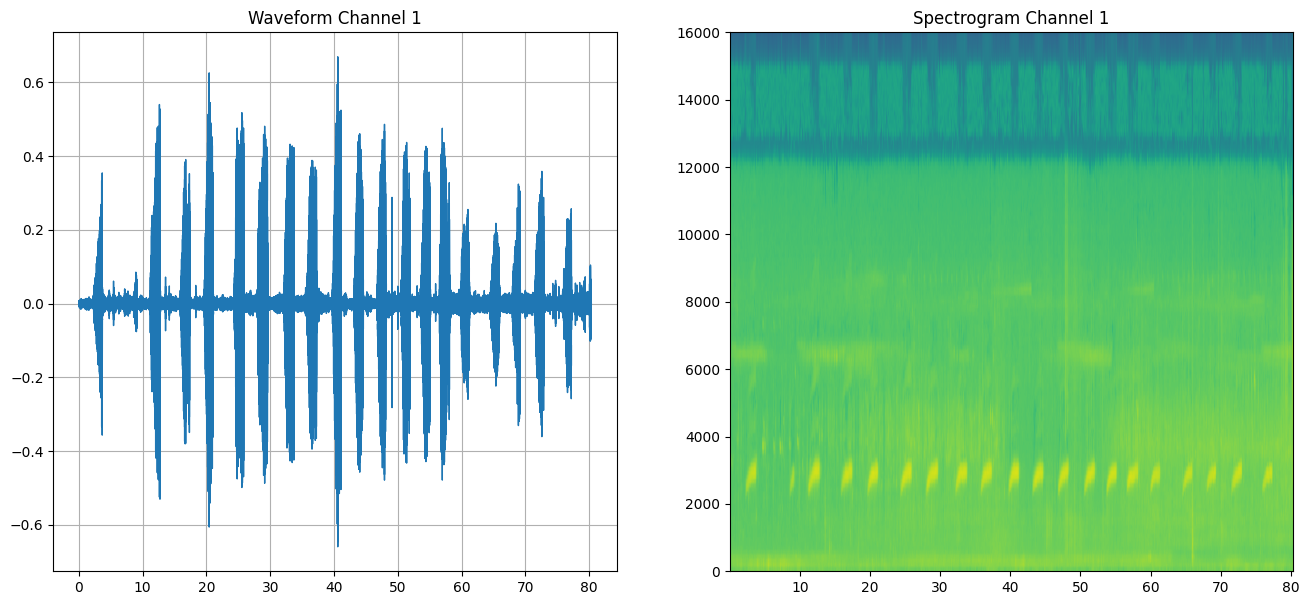

In [ ]:
#| eval: false
#@title Audio visualization

INDEX_EXAMPLE = 0 #@param {type:"slider", min:0, max:14655, step:1}

filename = AUDIO_DATA_DIR + oversampled_metadata['filename'][INDEX_EXAMPLE]
filedata = torchaudio.info(filename)
print(filedata)
print(metadata.iloc[INDEX_EXAMPLE, :])

waveform, sample_rate = torchaudio.load(filename)
plot_audio(waveform, sample_rate)
Audio(waveform.numpy(), rate=sample_rate)


## Train val test split

### Dividing the splits

In [ ]:
def split(split_metadata, folder=DATA_DIR, random_state=50):
    try:
        other_metadata, test_metadata = train_test_split(split_metadata, test_size=0.21, random_state=random_state, stratify=split_metadata.primary_label)
        train_metadata, val_metadata = train_test_split(other_metadata, test_size=0.26, random_state=random_state, stratify=split_metadata.primary_label)
    except ValueError as error:
        print(f'An exception occurred: {error}\nSplitting without stratify.')
        other_metadata, test_metadata = train_test_split(split_metadata, test_size=0.21, random_state=random_state)
        train_metadata, val_metadata = train_test_split(other_metadata, test_size=0.26, random_state=random_state)


    print(f'Train set:\n\tLength -> {train_metadata.shape[0]}\n\tClasses -> {len(train_metadata.primary_label.value_counts())}\n')
    print(f'Validation set:\n\tLength -> {val_metadata.shape[0]}\n\tClasses -> {len(val_metadata.primary_label.value_counts())}\n')
    print(f'Test set:\n\tLength -> {test_metadata.shape[0]}\n\tClasses -> {len(test_metadata.primary_label.value_counts())}\n')

    return train_metadata, test_metadata, val_metadata

In [ ]:
METADATA_DIR = DATA_DIR + 'base/'

train, test, val = split(split_metadata=metadata, folder=METADATA_DIR)

An exception occurred: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Splitting without stratify.
Train set:
	Length -> 9903
	Classes -> 261

Validation set:
	Length -> 3480
	Classes -> 244

Test set:
	Length -> 3558
	Classes -> 242



### Saving the splits

In [ ]:
train.to_csv(METADATA_DIR + 'train_metadata.csv')
val.to_csv(METADATA_DIR + 'val_metadata.csv')
test.to_csv(METADATA_DIR + 'test_metadata.csv')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()